In [2]:
import pandas as pd
# 저희는 Tabular Data를 다루기 때문에 아래 라이브러리를 호출합니다.
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt


c:\ProgramData\anaconda3\envs\autog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
bnum=54
drop_col = ['week', 'CDH',  'THI', 'max_power', 'min_power']
train54 = pd.read_csv(f'./submit/train_building{bnum}.csv').drop(columns=drop_col)

pretrain54 = pd.read_csv(f'./pretest/train_building{bnum}.csv').drop(columns=drop_col)
pretest54 = pd.read_csv(f'./pretest/pretest_building{bnum}.csv').drop(columns=drop_col)


In [16]:
pretrain = TabularDataset(pretrain54)
pretest = TabularDataset(pretest54)

In [17]:
predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(pretrain)

No path specified. Models will be saved in: "AutogluonModels\ag-20230824_124327\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230824_124327\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   41.94 GB / 499.43 GB (8.4%)
Train Data Rows:    1872
Train Data Columns: 18
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3766.68, 371.88, 1807.77933, 1121.50385)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available M

In [18]:
ld_board = predictor.leaderboard(pretrain, silent=True)

ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,-10658.716746,-44019.958421,0.045877,0.003990,1.459100,0.045877,0.003990,1.459100,1,True,11
1,ExtraTreesMSE,-12702.346979,-40140.926177,0.090756,0.045877,0.556512,0.090756,0.045877,0.556512,1,True,7
2,RandomForestMSE,-12980.976456,-41194.485990,0.107712,0.045878,0.780912,0.107712,0.045878,0.780912,1,True,5
3,XGBoost,-13584.370027,-38031.198822,0.025931,0.002992,0.491685,0.025931,0.002992,0.491685,1,True,9
4,LightGBM,-18242.473592,-40856.306205,0.023936,0.002992,0.586432,0.023936,0.002992,0.586432,1,True,4
5,CatBoost,-20738.368510,-33131.762120,0.013963,0.003990,1.389304,0.013963,0.003990,1.389304,1,True,6
6,WeightedEnsemble_L2,-21209.444158,-32869.833208,0.141623,0.025932,11.692864,0.013963,0.000000,0.330223,2,True,12
7,LightGBMXT,-25143.600988,-40064.607189,0.033910,0.005984,0.828783,0.033910,0.005984,0.828783,1,True,3
8,KNeighborsDist,-27806.643581,-138810.764651,0.012965,0.004987,0.005983,0.012965,0.004987,0.005983,1,True,2
9,NeuralNetFastAI,-34769.333657,-40108.976215,0.053856,0.009974,1.850053,0.053856,0.009974,1.850053,1,True,8


In [19]:
# 가장 우수한 모델의 이름을 가져옵니다.
best_model_name = predictor.get_model_best()

# 가장 우수한 모델로 예측 수행
predictions = predictor.predict(pretest, model=best_model_name)

# 예측 결과 출력
print(predictions)

0       729.696411
1       647.223389
2       653.508545
3       607.679443
4       605.969727
          ...     
163    2144.856689
164    1650.781738
165     957.769531
166     889.825195
167     932.610535
Name: power_consumption, Length: 168, dtype: float32


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='power_consumption'>)

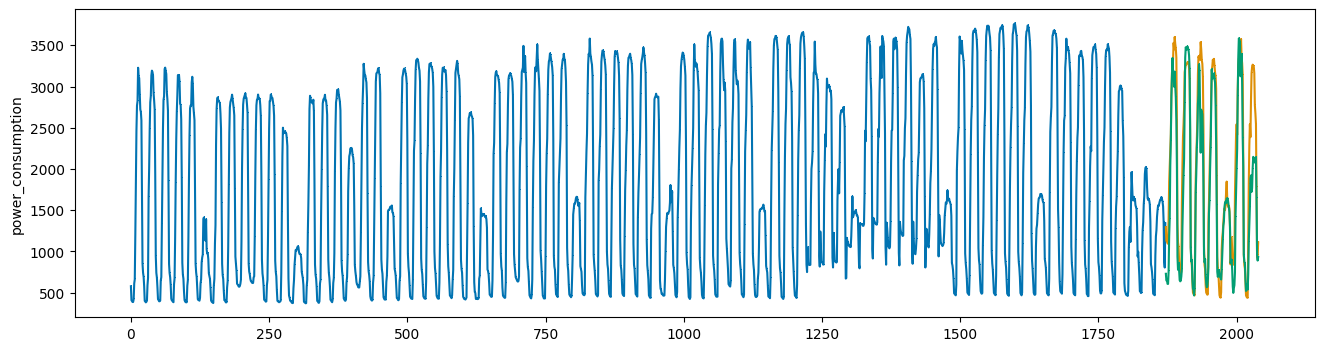

In [22]:

pretrain54_y = pretrain54['power_consumption']
test54_y = pretest54['power_consumption']
l = len(pretrain54_y)

predictions.index = np.arange(pretest54.index[0]+l, pretest54.index[-1]+1+l)
test54_y.index = np.arange(pretest54.index[0]+l, pretest54.index[-1]+1+l)
plot_series(pretrain54_y, test54_y, pd.Series(predictions), markers=[',' , ',', ','])

In [23]:

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [25]:
y_test_np = pretest54['power_consumption']
score = SMAPE(y_test_np, predictions)
print(score)

19.169899919339187


제출용

In [ ]:
i = 54
train_df = pd.read_csv(f'./submit/train_building{i}.csv')
test_df = pd.read_csv(f'./submit/test_building{i}.csv')

train = TabularDataset(train_df)
test = TabularDataset(test_df)

predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(train)

ld_board = predictor.leaderboard(train, silent=True)

ld_board

In [44]:
trash = pd.read_csv('./trash3.csv')
a = trash['1']
aa = a[0]
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [48]:
subm = pd.read_csv('./submission\ensemble_lbw_clust9_2_75_05_2.csv')
trash = pd.read_csv('./trash3.csv')
scores=[]
# bnum=[54]
bnum = trash['1']
k = trash['0']
drop_cols = [
[ 'week', 'THI', 'CDH', 'max_power', 'min_power','day_hour_mean','day_hour_std', 'hour_mean', 'hour_std','outlier','sensory','Rain_cat', 'close'],
[ 'week', 'THI', 'CDH', 'max_power', 'min_power' ,'day_hour_mean','day_hour_std','hour_mean', 'hour_std','sensory','Rain_cat', 'close'],
[ 'week', 'THI', 'CDH', 'max_power', 'min_power' , 'close'],
[ 'week','month','holiday', 'THI', 'CDH', 'day_hour_mean', 'day_hour_std','hour_mean', 'hour_std', 'max_power', 'min_power', 'THI_cat', 'sensory','Rain_cat', 'close'],
[ 'THI','hour_mean', 'hour_std', 'close'],
[ 'THI', 'CDH', 'Rain_cat', 'sensory'],
[ 'windspeed', 'week', 'CDH', 'sin_time', 'cos_time', 'THI', 'sensory', 'THI_cat','day_hour_mean', 'day_hour_std', 'hour_mean', 'hour_std', 'max_power', 'min_power','Rain_cat','close'],
[ 'week', 'THI', 'CDH', 'THI_cat', 'close' ],
[ 'week', 'month', 'THI', 'CDH', 'close', 'outlier', 'day_hour_mean', 'day_hour_std','hour_mean', 'hour_std', 'Rain_cat', 'cos_time', 'sin_time', 'temperature', 'sensory']
]
# drop_col=[ 'week', 'THI', 'CDH', 'max_power', 'min_power' , 'close']

#for i in bnum:
for j in range(len(bnum)):
    i = bnum[j]
    cl = k[j]
    drop_col = drop_cols[cl]
    # train_df = pd.read_csv(f'./submit/train_building{i}.csv').drop(columns=drop_col)
    # test_df = pd.read_csv(f'./submit/test_building{i}.csv').drop(columns=drop_col)
    train_df = pd.read_csv(f'./pretest/train_building{i}.csv').drop(columns=drop_col)
    test_df = pd.read_csv(f'./pretest/pretest_building{i}.csv').drop(columns=drop_col)
    answer = test_df['power_consumption']
    test_df = test_df.drop(columns='power_consumption')

    train = TabularDataset(train_df)
    test = TabularDataset(test_df)

    predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(train)

    # 가장 우수한 모델의 이름을 가져옵니다.
    best_model_name = predictor.get_model_best()

    # 가장 우수한 모델로 예측 수행
    predictions = predictor.predict(test, model=best_model_name)
    predictions_nd = np.array(predictions)
    subm.loc[subm.index[168*(i-1):168*i],'answer'] = predictions_nd

    # for idx, value in predictions.items():
    #     subm.loc[idx, 'answer'] = value
    score = SMAPE(answer, predictions)
    scores.append(score)

# subm.to_csv('./submission/ensemble_autog_54_33.csv', index = False)

No path specified. Models will be saved in: "AutogluonModels\ag-20230827_120609\"


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_120609\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   45.63 GB / 499.43 GB (9.1%)
Train Data Rows:    1872
Train Data Columns: 11
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1471.86, 206.82, 567.1701, 240.4418)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7430.3 MB
	Train Data (Original)  Memory Usage: 0.16 MB (0.0

[1000]	valid_set's l2: 4664.54


	-4656.0533	 = Validation score   (-mean_squared_error)
	1.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-4011.6908	 = Validation score   (-mean_squared_error)
	0.67s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4113.7862	 = Validation score   (-mean_squared_error)
	0.58s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-3657.0042	 = Validation score   (-mean_squared_error)
	2.61s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4083.8567	 = Validation score   (-mean_squared_error)
	0.43s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-4043.5429	 = Validation score   (-mean_squared_error)
	1.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-4019.0833	 = Validation score   (-mean_squared_error)
	0.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: Neur

[1000]	valid_set's l2: 4250.91
[2000]	valid_set's l2: 4076.49


	-4069.4626	 = Validation score   (-mean_squared_error)
	2.59s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	-4657.4561	 = Validation score   (-mean_squared_error)
	0.89s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-5581.6495	 = Validation score   (-mean_squared_error)
	0.59s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-3337.5634	 = Validation score   (-mean_squared_error)
	24.39s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-5504.4538	 = Validation score   (-mean_squared_error)
	0.47s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-4117.6058	 = Validation score   (-mean_squared_error)
	1.85s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-4634.6874	 = Validation score   (-mean_squared_error)
	0.73s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: Neu

[1000]	valid_set's l2: 4951.4


	-4950.21	 = Validation score   (-mean_squared_error)
	3.87s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3093.093	 = Validation score   (-mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 49.34s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_120637\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_120726\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_120726\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   45.44 GB / 499.43 GB (9.1%)
Train Data Rows:    1872
Train Data Columns: 12
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (becau

[1000]	valid_set's l2: 5451.49


	-5423.5079	 = Validation score   (-mean_squared_error)
	1.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-5273.618	 = Validation score   (-mean_squared_error)
	0.62s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-5152.3943	 = Validation score   (-mean_squared_error)
	0.56s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-5214.9645	 = Validation score   (-mean_squared_error)
	1.31s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-5573.0451	 = Validation score   (-mean_squared_error)
	0.41s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-8216.5741	 = Validation score   (-mean_squared_error)
	1.84s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-5386.2851	 = Validation score   (-mean_squared_error)
	0.44s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: Neura

[1000]	valid_set's l2: 33682


	-33491.5106	 = Validation score   (-mean_squared_error)
	1.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-32317.1795	 = Validation score   (-mean_squared_error)
	0.54s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-34662.8709	 = Validation score   (-mean_squared_error)
	0.58s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-25845.8627	 = Validation score   (-mean_squared_error)
	5.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-31608.9171	 = Validation score   (-mean_squared_error)
	0.42s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-42401.1906	 = Validation score   (-mean_squared_error)
	1.78s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-30901.8771	 = Validation score   (-mean_squared_error)
	0.68s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting mode

[1000]	valid_set's l2: 18331.4
[2000]	valid_set's l2: 18134.2


	-18027.3881	 = Validation score   (-mean_squared_error)
	2.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 20674.1


	-20639.7122	 = Validation score   (-mean_squared_error)
	1.26s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-17335.9225	 = Validation score   (-mean_squared_error)
	0.93s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-18420.3065	 = Validation score   (-mean_squared_error)
	6.39s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-17146.8464	 = Validation score   (-mean_squared_error)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-27798.4315	 = Validation score   (-mean_squared_error)
	1.74s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-16509.7668	 = Validation score   (-mean_squared_error)
	0.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-32928.8284	 = Validation score   (-mean_squared_error)
	4.68s	 = Training   runtime
	0.01s	 = Validation runtime
Fitti

[1000]	valid_set's l2: 10793.5


	-10791.3438	 = Validation score   (-mean_squared_error)
	2.67s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-8869.2378	 = Validation score   (-mean_squared_error)
	0.31s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 23.52s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_120907\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_120931\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_120931\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   44.94 GB / 499.43 GB (9.0%)
Train Data Rows:    1872
Train Data Columns: 20
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (b

[1000]	valid_set's l2: 4289.95


	-4263.0632	 = Validation score   (-mean_squared_error)
	1.33s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-5200.3749	 = Validation score   (-mean_squared_error)
	0.68s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-7441.7933	 = Validation score   (-mean_squared_error)
	0.82s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-4588.0366	 = Validation score   (-mean_squared_error)
	18.47s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-5443.6229	 = Validation score   (-mean_squared_error)
	0.48s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-7117.9368	 = Validation score   (-mean_squared_error)
	1.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-9200.1436	 = Validation score   (-mean_squared_error)
	0.81s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: Neu

[1000]	valid_set's l2: 5504.95


	-5504.7326	 = Validation score   (-mean_squared_error)
	3.77s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3916.4111	 = Validation score   (-mean_squared_error)
	0.31s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 42.71s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230827_120931\")
No path specified. Models will be saved in: "AutogluonModels\ag-20230827_121014\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230827_121014\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   44.85 GB / 499.43 GB (9.0%)
Train Data Rows:    1872
Train Data Columns: 8
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (bec

[1000]	valid_set's l2: 5568.43
[2000]	valid_set's l2: 5000.01
[3000]	valid_set's l2: 4905.36
[4000]	valid_set's l2: 4875.22
[5000]	valid_set's l2: 4875.4
[6000]	valid_set's l2: 4893.11


	-4855.3682	 = Validation score   (-mean_squared_error)
	5.06s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...
	-4488.3798	 = Validation score   (-mean_squared_error)
	0.89s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-4989.9649	 = Validation score   (-mean_squared_error)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-3419.5486	 = Validation score   (-mean_squared_error)
	3.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-4763.8243	 = Validation score   (-mean_squared_error)
	0.41s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-19376.2122	 = Validation score   (-mean_squared_error)
	1.7s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-4002.8191	 = Validation score   (-mean_squared_error)
	0.73s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: Neur

[1000]	valid_set's l2: 75690
[2000]	valid_set's l2: 74205.2
[3000]	valid_set's l2: 74238.7


	-73724.0685	 = Validation score   (-mean_squared_error)
	2.95s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	-70410.9253	 = Validation score   (-mean_squared_error)
	0.51s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-83636.5797	 = Validation score   (-mean_squared_error)
	0.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-68546.2677	 = Validation score   (-mean_squared_error)
	11.2s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-89667.9628	 = Validation score   (-mean_squared_error)
	0.42s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-92353.0541	 = Validation score   (-mean_squared_error)
	1.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-68801.8748	 = Validation score   (-mean_squared_error)
	0.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting mode

[1000]	valid_set's l2: 173926


	-171759.6266	 = Validation score   (-mean_squared_error)
	0.5s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-179169.2665	 = Validation score   (-mean_squared_error)
	0.49s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-164989.4309	 = Validation score   (-mean_squared_error)
	1.25s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-186096.6158	 = Validation score   (-mean_squared_error)
	0.4s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-202068.424	 = Validation score   (-mean_squared_error)
	1.84s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-177877.2108	 = Validation score   (-mean_squared_error)
	0.42s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-210036.5698	 = Validation score   (-mean_squared_error)
	7.32s	 = Training   runtime
	0.01s	 = Validation runtime
Fi

In [49]:
trash['auto_score']=scores
trash['diff']=trash['auto_score']-trash['2']

In [40]:
subm = pd.read_csv('./submission\ensemble_wsw_clust75_05_2.csv')
subm2 = pd.read_csv('./submission\ensemble_wsw_clust75_05_2.csv')
predictions_nd = np.array(predictions)
subm.loc[subm.index[168*(i-1):168*i],'answer'] = predictions_nd

In [50]:
subm.to_csv('./submission/ensemble_autog_clust9.csv', index = False)

In [33]:
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

i=54
test_df = pd.read_csv(f'./pretest/pretest_building{i}.csv').drop(columns=drop_col)
answer = test_df['power_consumption']
score = SMAPE(answer, predictions)
print(score)
scores.append(score)

19.169899919339187


In [ ]:
print(scores)

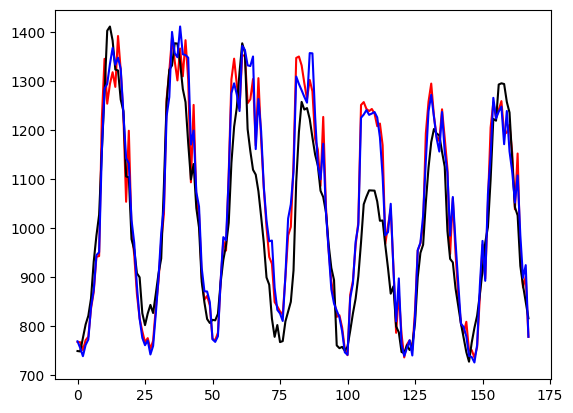

In [14]:
b_num = 95
x = pd.read_csv('./submission/submission_xgb_clust5.csv')
x = x.loc[x.index[168*(b_num-1):168*b_num],'answer']
l = pd.read_csv('./submission/lightGBM_wsw_clust5.csv')
l = l.loc[l.index[168*(b_num-1):168*b_num],'answer']
c = pd.read_csv('./submission/CatBoost_wsw_clust5.csv')
c = c.loc[c.index[168*(b_num-1):168*b_num],'answer']
e = pd.read_csv('./submission\ensemble_lbw_clust5_75_05_2.csv')
e = e.loc[e.index[168*(b_num-1):168*b_num],'answer']
a = pd.read_csv('./submission\submission_autog54_lbw.csv')
a = a.loc[a.index[168*(b_num-1):168*b_num],'answer']
# plt.plot(np.arange(168),x, color='m')
# plt.plot(np.arange(168),l, color='green')
# plt.plot(np.arange(168),c, color='blue')
plt.plot(np.arange(168),e, color='red')
plt.plot(np.arange(168),predictions, color='black')
plt.plot(np.arange(168),a, color='blue')
plt.show()

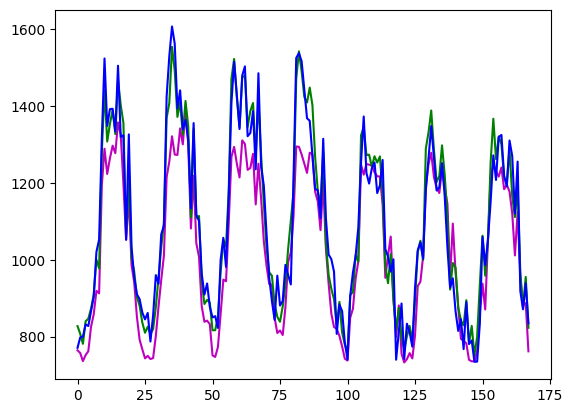

In [15]:
b_num = 95
x = pd.read_csv('./submission/submission_xgb_clust5.csv')
x = x.loc[x.index[168*(b_num-1):168*b_num],'answer']
l = pd.read_csv('./submission/lightGBM_wsw_clust7.csv')
l = l.loc[l.index[168*(b_num-1):168*b_num],'answer']
c = pd.read_csv('./submission/CatBoost_wsw_clust5.csv')
c = c.loc[c.index[168*(b_num-1):168*b_num],'answer']

plt.plot(np.arange(168),x, color='m')
plt.plot(np.arange(168),l, color='green')
plt.plot(np.arange(168),c, color='blue')

In [7]:
compare1 = pd.read_csv('./submission\submission_autog_more15_lbw.csv')
compare2 = pd.read_csv('./submission\submission_autog54_lbw.csv')
compare = compare1['answer'] - compare2['answer']

In [19]:
# 가장 우수한 모델의 이름을 가져옵니다.
best_model_name = predictor.get_model_best()

# 가장 우수한 모델로 예측 수행
predictions = predictor.predict(test, model=best_model_name)

# 예측 결과 출력
print(predictions)


In [20]:
subm = pd.read_csv('./submission\submission_autog_more15_lbw.csv')

for idx, value in predictions.items():
    subm.loc[idx, 'answer'] = value

subm.to_csv('./submission/submission_autog_more15_lbw.csv', index = False)


In [4]:
# autog54= pd.read_csv('./submission\submission_autog54_lbw.csv')
# autog542 = pd.read_csv('./submission\submission_autog54_lbw.csv')
# new_pred =  pd.read_csv('./submission\submission_xgb_wsw_mean_all_cat.csv')



# for i in [35,39,40,41,53,54,56,58,64,75,76,87,89,91,92]:
#     k = i - 1
#     index = k*168
#     autog54[index:index+168] = new_pred[index:index+168]


# autog54.to_csv('./submission/submission_autog_mean_all.csv', index = False)

